# Multi-Layer Perceptron (MLP), MNIST
---
<font color='cyan'> Responsible TA: AmirHossein Razlighi </font>

In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

This is a well-known and famous problem in the machine learning community! We try to train our network to recognize handwritten digits from 0 to 9. We use the famous MNIST dataset for this purpose. The dataset contains 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image. We will use the MLP to classify the images.

Let's proceed with the excersise!

In [1]:
# Run this code if you are trying to run the notebook locally
!python3 -m venv ./venv
!source ./venv/bin/activate

Error: Command '['/content/venv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: ./venv/bin/activate: No such file or directory


In [2]:
%pip install torch numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In this cell we first, download the dataset (using torch datasets) and then, create the test_set and train_sets to use in the rest of our notebook.
You can also change the `batch_size` in this cell to your desired amount.

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 106727808.94it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 8779221.18it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30896170.07it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13559095.21it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## See some of the training images

First thing to do in any machine learning task is to look at your data! load a batch of images from the training set and display them in a grid using the `imshow` function from `matplotlib.pyplot`. You can also use `torchvision.utils.make_grid` to create a grid from a list of images (batch).

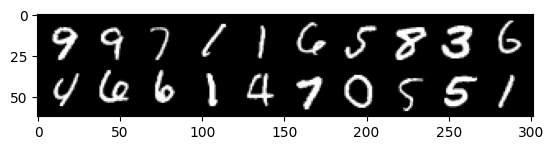

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

#TODO

# obtain one batch of training images


#create a grid and show a batch of images in training data

dataiter = iter(train_loader)
images, labels = next(dataiter)

grid = make_grid(images, nrow=10)
np_grid = grid.numpy()
plt.imshow(np.transpose(np_grid, (1, 2, 0)))
plt.show()


## View an Image in More Detail

Here, we look at one sample in a batch to see the pixel values (intensities). Note that our images are grayscale (even if the dataset were in RGB, the color data was irrelevant!) because for detecting the handwritten digits, the color of the ink of pen is not important (obviously)!

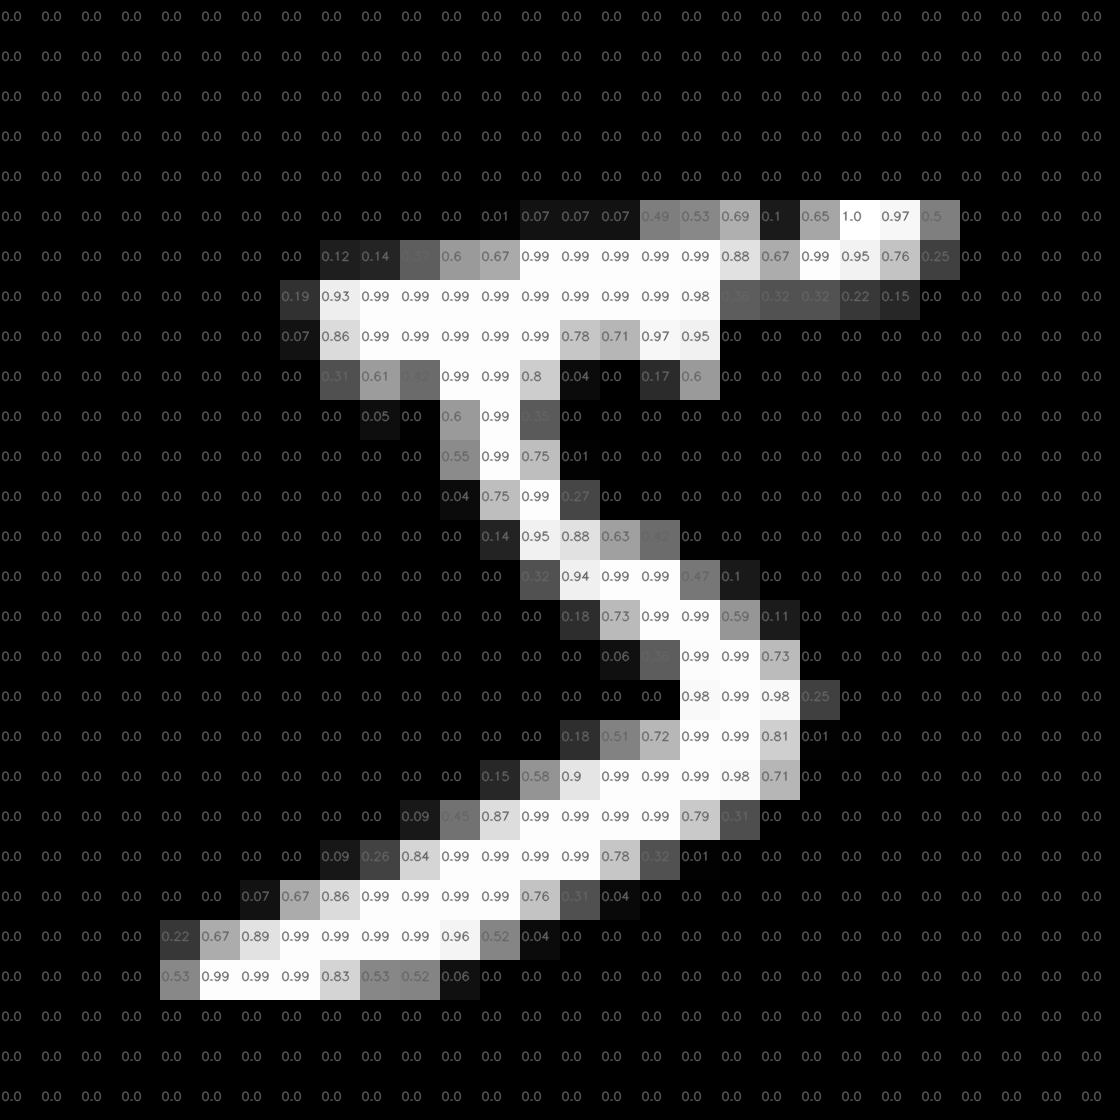

In [73]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

single_image, single_label = train_data[0]

# Convert the PyTorch tensor to a NumPy array
image_np = single_image.numpy()

# Convert the image to uint8
image_np = (image_np * 255).astype(np.uint8)

# Transpose the image dimensions from (C, H, W) to (H, W, C)
image_np = np.transpose(image_np, (1, 2, 0))

# Use the original image_np as the grayscale image
image = image_np[:,:,0]
si = 40
# Resize the image to make it larger
scaled_image = cv2.resize(image, None, fx=si, fy=si, interpolation=cv2.INTER_NEAREST)

# Get the image dimensions (height and width)
height, width = image.shape

# Iterate through each pixel and put the intensity value in the middle of the pixel
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.4
font_thickness = 1

for y in range(height):
    for x in range(width):
        intensity = image[y, x]
        # Position of the text on the scaled image
        position = (x * si + 1, y * si + (20))
        cv2.putText(scaled_image, str(round(float(intensity/255),2)), position, font, font_scale, (100, 100, 120), font_thickness, cv2.LINE_AA)
# Display the image
cv2_imshow(scaled_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

In this cell, you should define the network architecture. Note the dimensions of the input (print it out!) and the outputs. Your output should be a tensor of length 10 (digits 0 to 9) that indicates scores (probabilities) for an input image belonging to that class [$P(C_i|x)$]. Use `Drop out` layers to avoid overfitting!

In [74]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


##  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Here you should define the loss function used in training process and the optimizer. We recommend you use `cross-entropy` loss. But you can explore other loss functions if you think they work better in this case! Also, you can use `SGD` or `Adam` optimizer, or any other optimizers that you think would work better!

In [75]:
import torch.optim as optim

# Specify loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Complete the code below:

In [76]:
# Number of epochs to train the model
n_epochs = 30

for epoch in range(n_epochs):
    # Monitor training loss
    train_loss = 0.0

    # Training loop
    for data, target in train_loader:

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update average training loss
        train_loss += loss.item() * data.size(0)

    # Calculate average loss
    train_loss = train_loss / len(train_loader.dataset)

    print(f'Epoch: {epoch + 1} \tTraining Loss: {train_loss:.6f}')

Epoch: 1 	Training Loss: 0.222546
Epoch: 2 	Training Loss: 0.110548
Epoch: 3 	Training Loss: 0.087391
Epoch: 4 	Training Loss: 0.074790
Epoch: 5 	Training Loss: 0.066605
Epoch: 6 	Training Loss: 0.057742
Epoch: 7 	Training Loss: 0.054411
Epoch: 8 	Training Loss: 0.050585
Epoch: 9 	Training Loss: 0.048299
Epoch: 10 	Training Loss: 0.045850
Epoch: 11 	Training Loss: 0.042587
Epoch: 12 	Training Loss: 0.041659
Epoch: 13 	Training Loss: 0.041781
Epoch: 14 	Training Loss: 0.043249
Epoch: 15 	Training Loss: 0.038400
Epoch: 16 	Training Loss: 0.039803
Epoch: 17 	Training Loss: 0.037509
Epoch: 18 	Training Loss: 0.035761
Epoch: 19 	Training Loss: 0.037940
Epoch: 20 	Training Loss: 0.035286
Epoch: 21 	Training Loss: 0.034322
Epoch: 22 	Training Loss: 0.038155
Epoch: 23 	Training Loss: 0.034678
Epoch: 24 	Training Loss: 0.032360
Epoch: 25 	Training Loss: 0.036139
Epoch: 26 	Training Loss: 0.035455
Epoch: 27 	Training Loss: 0.037317
Epoch: 28 	Training Loss: 0.032395
Epoch: 29 	Training Loss: 0.0

---
## Test the Trained Network

And at last, you should test the model on test_set (previously unseen data). We will use test_set to evaluate the model's performance. Don't forget to prepare the model for evaluation(testing) using `model.eval()` in Pytorch!

You should report the Test Accuracy of your model.

In [77]:
model.eval()

# Initialize variables
correct = 0
total = 0

# Iterate over the test_loader
i = 0
for data, target in test_loader:

    # Perform a forward pass
    output = model(data)

    # Get the predicted labels
    _, predicted = torch.max(output.data, 1)

    # Count the number of correct predictions
    correct += (predicted == target).sum().item()
    total += target.size(0)
    print(f'Test Accuracy of \t{i}: {(predicted == target).sum().item()/target.size(0) * 100:.2f}% ({(predicted == target).sum().item()}/{target.size(0)})')
    i += 1

# Calculate test accuracy
test_accuracy = correct / total

print(f'Test Accuracy (Overall) : {test_accuracy * 100:.2f}%')


Test Accuracy of 	0: 100.00% (20/20)
Test Accuracy of 	1: 100.00% (20/20)
Test Accuracy of 	2: 100.00% (20/20)
Test Accuracy of 	3: 95.00% (19/20)
Test Accuracy of 	4: 95.00% (19/20)
Test Accuracy of 	5: 100.00% (20/20)
Test Accuracy of 	6: 100.00% (20/20)
Test Accuracy of 	7: 100.00% (20/20)
Test Accuracy of 	8: 100.00% (20/20)
Test Accuracy of 	9: 95.00% (19/20)
Test Accuracy of 	10: 100.00% (20/20)
Test Accuracy of 	11: 95.00% (19/20)
Test Accuracy of 	12: 95.00% (19/20)
Test Accuracy of 	13: 95.00% (19/20)
Test Accuracy of 	14: 100.00% (20/20)
Test Accuracy of 	15: 100.00% (20/20)
Test Accuracy of 	16: 100.00% (20/20)
Test Accuracy of 	17: 100.00% (20/20)
Test Accuracy of 	18: 100.00% (20/20)
Test Accuracy of 	19: 95.00% (19/20)
Test Accuracy of 	20: 100.00% (20/20)
Test Accuracy of 	21: 100.00% (20/20)
Test Accuracy of 	22: 100.00% (20/20)
Test Accuracy of 	23: 100.00% (20/20)
Test Accuracy of 	24: 100.00% (20/20)
Test Accuracy of 	25: 100.00% (20/20)
Test Accuracy of 	26: 95.00% 

### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

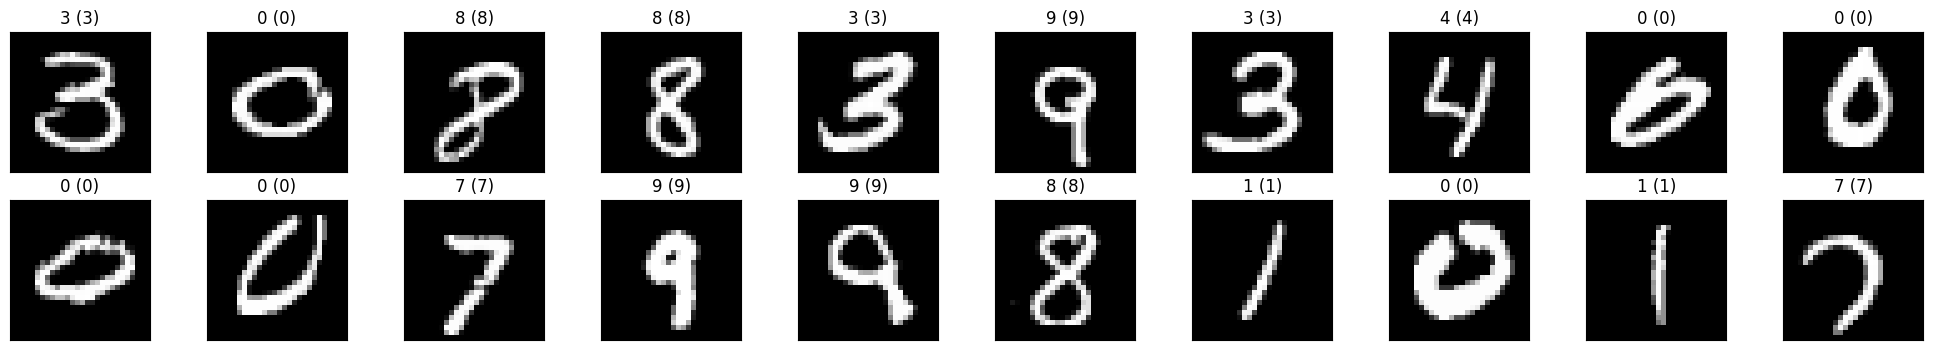

In [86]:
def imshow(img):
    img = img.numpy().squeeze()
    plt.imshow(img, cmap='gray')

dataiter = iter(test_loader)
images, labels = next(dataiter)

output = model(images)

_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())))
